# Mini-Projet : Prédiction du revenu annuel d'un marocain

**Auteurs :** [YourNames]

**Date :** Mai 2025

**Cours :** Intelligence Artificielle - 2ème année Cycle d'ingénieurs – GI

**Professeur :** Y. EL YOUNOUSSI

## 1. Introduction

Ce mini-projet a pour objectif de construire un pipeline complet de Machine Learning en Python pour prédire le revenu annuel des Marocains à partir de données simulées réalistes. Le projet couvre toutes les étapes du développement d'un modèle de Machine Learning : la génération et la compréhension des données, la préparation des données, la modélisation, l'évaluation et le déploiement.

Les données sont générées en respectant les statistiques du Haut-Commissariat au Plan (HCP) concernant les revenus des Marocains, avec une attention particulière aux différences entre les milieux urbains et ruraux, ainsi qu'aux facteurs démographiques qui influencent les revenus.

## 2. Importation des bibliothèques

In [1]:
# Configuration pour affichage des graphiques dans le notebook
%matplotlib inline

# Bibliothèques pour la manipulation et l'analyse des données
import numpy as np
import pandas as pd
from datetime import datetime
import random

# Bibliothèques pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Pour l'analyse exploratoire automatisée
import sweetviz as sv

# Bibliothèques de machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modèles
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Pour le déploiement (sera utilisé plus tard)
import joblib

# Pour assurer la reproductibilité
np.random.seed(42)
random.seed(42)

## 3. Phase 1 : Génération de données synthétiques

### 3.1 Contraintes statistiques

Selon les données du HCP, nous devons respecter les contraintes suivantes :

1. **Revenu moyen** :
   - Global : 21,949 DH/an
   - Urbain : 26,988 DH/an
   - Rural : 12,862 DH/an

2. **Répartition des revenus** :
   - 71.8% des personnes ont un revenu inférieur à la moyenne globale
   - En milieu urbain : 65.9% ont un revenu inférieur à la moyenne urbaine
   - En milieu rural : 85.4% ont un revenu inférieur à la moyenne rurale

Nous définissons ces contraintes comme des constantes :

In [2]:
# Définition des constantes basées sur les exigences du projet
# Statistiques de revenus du HCP (Haut-Commissariat au Plan)
REVENU_MOYEN_GLOBAL = 21949  # DH/an
REVENU_MOYEN_URBAIN = 26988  # DH/an
REVENU_MOYEN_RURAL = 12862   # DH/an

# Statistiques de distribution des revenus
PCT_BELOW_MEAN_GLOBAL = 0.718  # 71.8% sous la moyenne
PCT_BELOW_MEAN_URBAIN = 0.659  # 65.9% sous la moyenne en milieu urbain
PCT_BELOW_MEAN_RURAL = 0.854   # 85.4% sous la moyenne en milieu rural

# Taille de l'échantillon
N_SAMPLES = 40000

### 3.2 Génération des données démographiques

Nous allons générer des données démographiques pour 40 000 individus, avec des attributs tels que l'âge, le sexe, le niveau d'éducation, les années d'expérience, etc. Les distributions et corrélations entre ces attributs sont conçues pour refléter la réalité marocaine.

Dans cette fonction, nous générons :
1. Les données de base (âge, catégorie d'âge, milieu, sexe)
2. Le niveau d'éducation (corrélé avec l'âge)
3. Les années d'expérience (calculées en fonction de l'âge et de l'éducation)
4. L'état matrimonial (corrélé avec l'âge)
5. La catégorie socioprofessionnelle (corrélée avec l'éducation)
6. La possession de biens (corrélée avec la catégorie socioprofessionnelle)
7. D'autres caractéristiques (nombre d'enfants, taille du ménage, accès à internet)

In [3]:
def generate_demographics(n_samples=N_SAMPLES):
    """
    Génère des données démographiques réalistes pour n_samples individus marocains.
    
    Args:
        n_samples (int): Nombre d'individus à générer
        
    Returns:
        pandas.DataFrame: DataFrame contenant les caractéristiques démographiques
    """
    demographics = pd.DataFrame()
    
    # 1. Âge : le revenu a tendance d'augmenter lorsqu'on se rapproche de l'âge de retraite
    demographics['age'] = np.random.normal(loc=35, scale=12, size=n_samples).astype(int) 
    demographics['age'] = np.clip(demographics['age'], 18, 80)

    # 2. Catégorie d'âge : jeune, adulte, sénior et âgé
    demographics['categorie_age'] = pd.cut(
        demographics['age'], 
        bins=[0, 25, 45, 65, 100],
        labels=['jeune', 'adulte', 'sénior', 'âgé']
    )

    # 3. Urbain/Rural : les personnes issues du milieu urbain ont tendance à gagner plus
    # que les personnes du milieu rural (63% urbain, selon les statistiques marocaines)
    demographics['milieu'] = np.random.choice(['urbain', 'rural'], size=n_samples, p=[0.63, 0.37])

    # 4. Sexe : le revenu moyen des hommes est plus élevé que celui des femmes
    demographics['sexe'] = np.random.choice(['homme', 'femme'], size=n_samples, p=[0.51, 0.49])

    # 5. Niveau d'éducation : quatre niveaux (corrélé avec l'âge)
    education_levels = ['sans_niveau', 'fondamental', 'secondaire', 'supérieur']
    
    # Probabilités d'éducation selon la catégorie d'âge
    education_probs = {
      'jeune': [0.05, 0.25, 0.40, 0.30],  # Les jeunes ont plus souvent une éducation secondaire ou supérieure
      'adulte': [0.15, 0.35, 0.30, 0.20],
      'sénior': [0.30, 0.40, 0.20, 0.10],
      'âgé': [0.50, 0.30, 0.15, 0.05]     # Les personnes âgées ont plus souvent un niveau d'éducation faible
    }
    
    demographics['niveau_education'] = demographics.apply(
      lambda row: np.random.choice(education_levels, p=education_probs[row['categorie_age']]),
      axis=1
    )
    
    # 6. Années d'expérience : calculées en fonction de l'âge et du niveau d'éducation
    demographics['annees_experience'] = demographics.apply(
        lambda row: max(0, min(row['age'] - 18 - (4 if row['niveau_education'] == 'supérieur' else 
                                            2 if row['niveau_education'] == 'secondaire' else 
                                            0 if row['niveau_education'] == 'fondamental' else 0),
                      row['age'] - 15)) + np.random.randint(-2, 3),
        axis=1
    )
    demographics['annees_experience'] = np.clip(demographics['annees_experience'], 0, 50)
    
    # 7. État matrimonial : corrélé avec l'âge
    marital_status = ['célibataire', 'marié', 'divorcé', 'veuf']
    marital_probs = {
        'jeune': [0.80, 0.18, 0.02, 0.00],
        'adulte': [0.25, 0.65, 0.08, 0.02],
        'sénior': [0.10, 0.70, 0.10, 0.10],
        'âgé': [0.05, 0.55, 0.10, 0.30]
    }
    
    demographics['etat_matrimonial'] = demographics.apply(
        lambda row: np.random.choice(marital_status, p=marital_probs[row['categorie_age']]), 
        axis=1
    )

    # 8. Catégorie socioprofessionnelle : corrélée avec le niveau d'éducation
    socio_prof_categories = ['Groupe_1', 'Groupe_2', 'Groupe_3', 'Groupe_4', 'Groupe_5', 'Groupe_6']
    socio_prof_probs = {
        'sans_niveau': [0.01, 0.03, 0.10, 0.25, 0.25, 0.36],
        'fondamental': [0.03, 0.10, 0.15, 0.22, 0.30, 0.20],
        'secondaire': [0.10, 0.25, 0.20, 0.10, 0.25, 0.10],
        'supérieur': [0.40, 0.35, 0.15, 0.02, 0.05, 0.03]
    }
    
    demographics['categorie_socioprofessionnelle'] = demographics.apply(
        lambda row: np.random.choice(socio_prof_categories, p=socio_prof_probs[row['niveau_education']]), 
        axis=1
    )

    # 9. Possession de biens : corrélée avec la catégorie socioprofessionnelle
    group_weights = {
        'Groupe_1': 0.9, 'Groupe_2': 0.7, 'Groupe_3': 0.5, 
        'Groupe_4': 0.3, 'Groupe_5': 0.2, 'Groupe_6': 0.1
    }
    
    demographics['possession_voiture'] = demographics.apply(
        lambda row: np.random.choice([1, 0], p=[group_weights[row['categorie_socioprofessionnelle']], 
                                               1-group_weights[row['categorie_socioprofessionnelle']]]),
        axis=1
    )
    
    demographics['possession_logement'] = demographics.apply(
        lambda row: np.random.choice([1, 0], p=[np.clip(group_weights[row['categorie_socioprofessionnelle']]*0.8, 0, 1),
                                              1-np.clip(group_weights[row['categorie_socioprofessionnelle']]*0.8, 0, 1)]),
        axis=1
    )
    
    demographics['possession_terrain'] = demographics.apply(
        lambda row: np.random.choice([1, 0], p=[np.clip(group_weights[row['categorie_socioprofessionnelle']]*0.4, 0, 1),
                                              1-np.clip(group_weights[row['categorie_socioprofessionnelle']]*0.4, 0, 1)]),
        axis=1
    )

    # 10. Caractéristiques supplémentaires (au moins 3 selon les exigences du projet)
    
    # a. Nombre d'enfants
    demographics['nombre_enfants'] = demographics.apply(
        lambda row: np.random.poisson(2) if row['etat_matrimonial'] in ['marié', 'divorcé', 'veuf'] else
                   (np.random.binomial(1, 0.05) if row['etat_matrimonial'] == 'célibataire' else 0),
        axis=1
    )
    
    # b. Taille du ménage
    demographics['taille_menage'] = demographics.apply(
        lambda row: row['nombre_enfants'] + (2 if row['etat_matrimonial'] == 'marié' else 1),
        axis=1
    )
    
    # c. Accès à Internet (plus courant en milieu urbain et avec un niveau d'éducation élevé)
    urban_factor = demographics['milieu'].apply(lambda x: 0.9 if x == 'urbain' else 0.4)
    education_factor = demographics['niveau_education'].apply(
        lambda x: 0.95 if x == 'supérieur' else 0.8 if x == 'secondaire' else 0.5 if x == 'fondamental' else 0.2
    )
    
    internet_prob = np.clip((urban_factor + education_factor) / 2, 0, 1)
    
    demographics['acces_internet'] = demographics.apply(
        lambda row: np.random.choice([1, 0], p=[internet_prob[row.name], 1-internet_prob[row.name]]),
        axis=1
    )
    
    return demographics

### 3.3 Génération des revenus

Maintenant, nous allons générer les revenus en fonction des caractéristiques démographiques. Le revenu de chaque individu sera influencé par son milieu (urbain/rural), son niveau d'éducation, son expérience, son sexe, sa catégorie socioprofessionnelle et ses possessions.

In [11]:
def generate_income(demographics_df):
    """
    Génère des revenus annuels basés sur les caractéristiques démographiques.
    Les revenus suivent une distribution réaliste tout en respectant les contraintes
    statistiques du HCP.
    
    Args:
        demographics_df (pandas.DataFrame): DataFrame contenant les caractéristiques démographiques
        
    Returns:
        numpy.ndarray: Tableau des revenus annuels générés
    """
    import numpy as np
    from scipy import stats
    
    # Création d'une copie pour éviter les modifications du DataFrame original
    df = demographics_df.copy()
    
    # Séparation urbain/rural pour un traitement indépendant
    urban_mask = df['milieu'] == 'urbain'
    rural_mask = ~urban_mask
    
    # Initialisation du vecteur de revenus
    income = np.zeros(len(df))
    
    # Fonction pour générer les revenus pour un segment spécifique
    def generate_segment_income(segment_mask, mean_target, pct_below_mean):
        segment_size = segment_mask.sum()
        segment_df = df.loc[segment_mask].copy()
        
        # Calcul des paramètres optimaux de la distribution log-normale
        # Dans une log-normale, la proportion sous la moyenne est liée au sigma
        # Nous devons trouver le sigma qui donne exactement le pourcentage cible
        
        # Pour une log-normale, le pourcentage sous la moyenne est:
        # P(X < μ) = Φ(σ/sqrt(2)), où Φ est la CDF de la loi normale standard
        
        # Inversement, à partir du pourcentage, on peut calculer sigma:
        # sigma = sqrt(2) * Φ^(-1)(pct_below_mean)
        # où Φ^(-1) est l'inverse de la CDF de la loi normale standard
        
        # Calcul de sigma optimal
        sigma = np.sqrt(2) * stats.norm.ppf(pct_below_mean)
        
        # Calcul de mu (tel que la moyenne de la distribution log-normale soit mean_target)
        # Pour une log-normale, E[X] = exp(mu + sigma²/2)
        # D'où: mu = ln(mean_target) - sigma²/2
        mu = np.log(mean_target) - (sigma**2)/2
        
        # Génération du revenu de base avec distribution log-normale optimisée
        base_income = np.random.lognormal(mean=mu, sigma=sigma, size=segment_size)
        
        # Vérification (uniquement pour le développement, peut être commenté en production)
        actual_mean = base_income.mean()
        actual_pct_below = (base_income < mean_target).mean()
        print(f"Distribution - Mean: {actual_mean:.2f} (target: {mean_target:.2f}), "
              f"Pct below: {actual_pct_below*100:.1f}% (target: {pct_below_mean*100:.1f}%)")
        
        # Matrice de modifications basée sur les caractéristiques démographiques
        modifiers = np.ones(segment_size)
        
        # --- Application des facteurs influençant le revenu ---
        
        # 1. Niveau d'éducation
        education_impact = {
            'sans_niveau': 0.75,
            'fondamental': 0.9,
            'secondaire': 1.1,
            'supérieur': 1.4
        }
        for edu, impact in education_impact.items():
            modifiers[segment_df['niveau_education'] == edu] *= impact
        
        # 2. Années d'expérience (effet modéré avec plafond)
        exp_values = segment_df['annees_experience'].values
        exp_modifier = 1 + 0.01 * exp_values
        exp_modifier = np.minimum(exp_modifier, 1.3)
        modifiers *= exp_modifier
        
        # 3. Catégorie socioprofessionnelle
        socio_prof_impact = {
            'Groupe_1': 1.5,  # Cadres supérieurs
            'Groupe_2': 1.3,  # Cadres moyens
            'Groupe_3': 1.1,  # Inactifs avec revenus
            'Groupe_4': 0.9,  # Agriculteurs
            'Groupe_5': 0.85, # Artisans, ouvriers
            'Groupe_6': 0.8   # Travailleurs non qualifiés
        }
        for group, impact in socio_prof_impact.items():
            modifiers[segment_df['categorie_socioprofessionnelle'] == group] *= impact
        
        # 4. Sexe (facteurs modérés)
        modifiers[segment_df['sexe'] == 'homme'] *= 1.1
        modifiers[segment_df['sexe'] == 'femme'] *= 0.9
        
        # 5. Âge (fonction en cloche)
        age_values = segment_df['age'].values
        age_modifier = 0.85 + 0.3 * np.exp(-0.002 * (age_values - 45)**2)
        modifiers *= age_modifier
        
        # Appliquer les multiplicateurs en préservant les rangs
        # Pour ce faire, nous réorganisons les revenus de base selon les rangs des modificateurs
        
        # Trier les revenus de base
        sorted_base_income = np.sort(base_income)
        
        # Obtenir les rangs des modificateurs
        modifier_ranks = stats.rankdata(modifiers, method='ordinal') - 1
        
        # Réorganiser les revenus de base selon les rangs des modificateurs
        # Cela préserve la distribution tout en créant une corrélation avec les facteurs démographiques
        income_with_factors = np.zeros_like(base_income)
        for i, rank in enumerate(modifier_ranks):
            income_with_factors[i] = sorted_base_income[rank]
        
        # Réajuster la moyenne pour compenser les effets de la réorganisation
        adjusted_income = income_with_factors * (mean_target / income_with_factors.mean())
        
        return adjusted_income
    
    # Génération des revenus pour la population urbaine
    if urban_mask.sum() > 0:
        urban_income = generate_segment_income(urban_mask, REVENU_MOYEN_URBAIN, PCT_BELOW_MEAN_URBAIN)
        income[urban_mask] = urban_income
    
    # Génération des revenus pour la population rurale
    if rural_mask.sum() > 0:
        rural_income = generate_segment_income(rural_mask, REVENU_MOYEN_RURAL, PCT_BELOW_MEAN_RURAL)
        income[rural_mask] = rural_income
    
    return income

### 3.5 Fonction de vérification des contraintes

Cette fonction nous permet de vérifier si les contraintes statistiques sont respectées dans notre jeu de données.

In [5]:
def verify_income_constraints(demographics_df):
    """
    Vérifie si les contraintes sur les revenus sont respectées et affiche un tableau comparatif.
    
    Args:
        demographics_df (pandas.DataFrame): DataFrame avec les données démographiques et de revenu
    """
    # Calcul des statistiques réelles
    actual_mean_global = demographics_df['revenu_annuel'].mean()
    
    urban_mask = demographics_df['milieu'] == 'urbain'
    rural_mask = ~urban_mask
    
    actual_mean_urbain = demographics_df.loc[urban_mask, 'revenu_annuel'].mean()
    actual_mean_rural = demographics_df.loc[rural_mask, 'revenu_annuel'].mean()
    
    actual_below_mean_global = (demographics_df['revenu_annuel'] < REVENU_MOYEN_GLOBAL).mean()
    actual_below_mean_urbain = (demographics_df.loc[urban_mask, 'revenu_annuel'] < REVENU_MOYEN_URBAIN).mean()
    actual_below_mean_rural = (demographics_df.loc[rural_mask, 'revenu_annuel'] < REVENU_MOYEN_RURAL).mean()
    
    # Création des données de comparaison
    data = {
        'Statistique': [
            'Revenu moyen global (DH/an)',
            'Revenu moyen urbain (DH/an)',
            'Revenu moyen rural (DH/an)',
            '% global < moyenne',
            '% urbain < moyenne',
            '% rural < moyenne'
        ],
        'Cible': [
            f"{REVENU_MOYEN_GLOBAL:.2f}",
            f"{REVENU_MOYEN_URBAIN:.2f}",
            f"{REVENU_MOYEN_RURAL:.2f}",
            f"{PCT_BELOW_MEAN_GLOBAL*100:.1f}%",
            f"{PCT_BELOW_MEAN_URBAIN*100:.1f}%",
            f"{PCT_BELOW_MEAN_RURAL*100:.1f}%"
        ],
        'Résultat': [
            f"{actual_mean_global:.2f}",
            f"{actual_mean_urbain:.2f}",
            f"{actual_mean_rural:.2f}",
            f"{actual_below_mean_global*100:.1f}%",
            f"{actual_below_mean_urbain*100:.1f}%",
            f"{actual_below_mean_rural*100:.1f}%"
        ],
        'Écart': [
            f"{actual_mean_global - REVENU_MOYEN_GLOBAL:.2f}",
            f"{actual_mean_urbain - REVENU_MOYEN_URBAIN:.2f}",
            f"{actual_mean_rural - REVENU_MOYEN_RURAL:.2f}",
            f"{(actual_below_mean_global - PCT_BELOW_MEAN_GLOBAL)*100:.1f}%",
            f"{(actual_below_mean_urbain - PCT_BELOW_MEAN_URBAIN)*100:.1f}%",
            f"{(actual_below_mean_rural - PCT_BELOW_MEAN_RURAL)*100:.1f}%"
        ]
    }
    
    # Création du DataFrame pour l'affichage
    comparison_df = pd.DataFrame(data)
    
    # Affichage du tableau avec mise en forme
    from IPython.display import display, HTML
    
    # Application de la mise en forme pour mettre en évidence les écarts
    def highlight_discrepancies(val):
        if isinstance(val, str):
            if '%' in val:
                if float(val.strip('%')) > 1.0 or float(val.strip('%')) < -1.0:
                    return 'background-color: yellow'
            else:
                if float(val) > 100 or float(val) < -100:
                    return 'background-color: yellow'
        return ''
    
    # Application de la mise en forme et affichage
    styled_df = comparison_df.style.map(highlight_discrepancies, subset=['Écart'])
    
    # Ajout d'un titre et affichage
    print("\n=== Vérification des contraintes statistiques ===\n")
    display(styled_df)
    
    # Ajout d'une évaluation sommaire
    mean_errors = [abs(actual_mean_global - REVENU_MOYEN_GLOBAL),
                  abs(actual_mean_urbain - REVENU_MOYEN_URBAIN),
                  abs(actual_mean_rural - REVENU_MOYEN_RURAL)]
    
    pct_errors = [abs(actual_below_mean_global - PCT_BELOW_MEAN_GLOBAL),
                 abs(actual_below_mean_urbain - PCT_BELOW_MEAN_URBAIN),
                 abs(actual_below_mean_rural - PCT_BELOW_MEAN_RURAL)]
    
    if max(mean_errors) < 100 and max(pct_errors) < 0.02:
        print("\n✓ Les contraintes statistiques sont bien respectées!")
    else:
        print("\n⚠ Certaines contraintes statistiques ne sont pas parfaitement respectées.")
        print("   Vous pourriez ajuster les paramètres de génération des revenus.")
    
    # Affichage de statistiques supplémentaires sur le jeu de données
    print(f"\nNombre total d'enregistrements: {len(demographics_df)}")
    print(f"Proportion urbain/rural: {sum(urban_mask)/len(demographics_df)*100:.1f}% / {sum(rural_mask)/len(demographics_df)*100:.1f}%")

### 3.6 Génération du jeu de données complet

Maintenant, utilisons toutes nos fonctions pour générer le jeu de données complet.

In [21]:
# Génération des données démographiques
demographics_df = generate_demographics()

# Génération des revenus 
income = generate_income(demographics_df)

# Ajout des revenus au DataFrame
demographics_df['revenu_annuel'] = income

# Vérification des contraintes statistiques
verify_income_constraints(demographics_df)

demographics_df.sample(10)


Distribution - Mean: 26845.44 (target: 26988.00), Pct below: 61.9% (target: 65.9%)
Distribution - Mean: 12842.93 (target: 12862.00), Pct below: 76.9% (target: 85.4%)

=== Vérification des contraintes statistiques ===



,Statistique,Cible,Résultat,Écart
0,Revenu moyen global (DH/an),21949.00,21771.62,-177.38
1,Revenu moyen urbain (DH/an),26988.00,26988.00,-0.00
2,Revenu moyen rural (DH/an),12862.00,12862.00,0.00
3,% global < moyenne,71.8%,61.8%,-10.0%
4,% urbain < moyenne,65.9%,61.5%,-4.4%
5,% rural < moyenne,85.4%,76.8%,-8.6%



⚠ Certaines contraintes statistiques ne sont pas parfaitement respectées.
   Vous pourriez ajuster les paramètres de génération des revenus.

Nombre total d'enregistrements: 40000
Proportion urbain/rural: 63.1% / 36.9%


,age,categorie_age,milieu,sexe,niveau_education,annees_experience,etat_matrimonial,categorie_socioprofessionnelle,possession_voiture,possession_logement,possession_terrain,nombre_enfants,taille_menage,acces_internet,revenu_annuel
19388,33,adulte,rural,homme,supérieur,12,marié,Groupe_1,1,1,0,2,4,1,87931.023139
25828,44,adulte,rural,homme,secondaire,24,marié,Groupe_1,1,1,1,3,5,0,57741.424204
2170,33,adulte,rural,femme,secondaire,12,marié,Groupe_3,0,0,0,1,3,1,5843.565668
8391,22,jeune,urbain,homme,secondaire,2,célibataire,Groupe_3,0,0,0,0,1,1,25126.731674
15593,25,jeune,urbain,femme,secondaire,4,célibataire,Groupe_3,0,1,0,0,1,1,20572.747167
8060,18,jeune,urbain,femme,fondamental,2,célibataire,Groupe_6,0,0,0,0,1,1,5983.202583
5359,23,jeune,urbain,homme,secondaire,1,marié,Groupe_2,1,1,1,1,3,1,30173.790911
30375,56,sénior,rural,homme,secondaire,35,marié,Groupe_2,1,1,0,1,3,0,31139.052162
39308,29,adulte,urbain,femme,fondamental,10,marié,Groupe_1,0,1,0,2,4,0,26870.903453
10859,46,sénior,rural,femme,sans_niveau,27,veuf,Groupe_6,0,0,0,2,3,0,634.723885


### 3.7 Ajout des problèmes de qualité des données

Nous devons introduire intentionnellement des problèmes de qualité des données tels que des **valeurs manquantes**, des **valeurs aberrantes**, des **colonnes redondantes** et des **colonnes non pertinentes**.

Pour répondre à cette exigence de manière structurée, nous avons développé quatre fonctions spécialisées, chacune ciblant un type spécifique de problème de qualité. Cette approche nous permettra d'illustrer différentes techniques de nettoyage et de préparation des données dans les phases ultérieures.

#### 3.7.1 Ajout de valeurs manquantes

Notre stratégie pour l'ajout de valeurs manquantes suit une approche méthodologique basée sur les types de données manquantes reconnus en statistique :

1. **Valeurs manquantes chez les personnes âgées (MAR - Missing At Random)** :
   - 15% des personnes de catégorie "âgé" ont une valeur manquante pour leur niveau d'éducation
   - Ce pattern simule une réalité sociologique où les données éducatives des personnes âgées sont souvent moins bien documentées
   - Cette approche nous permettra de démontrer *l'imputation conditionnelle basée sur l'âge et d'autres variables socio-démographiques*

2. **Valeurs manquantes pour les possessions des hauts revenus (MNAR - Missing Not At Random)** :
   - 20% des personnes dans le quintile supérieur de revenu ont une valeur manquante pour la possession de terrain
   - Ce pattern reflète une tendance réelle où les personnes fortunées sont souvent plus réticentes à divulguer l'étendue de leurs biens
   - Cette situation nous permettra d'illustrer les biais d'échantillonnage et les techniques d'imputation avancées

3. **Valeurs manquantes complètement aléatoires dans l'expérience professionnelle (MCAR - Missing Completely At Random)** :
   - 3% des individus, sélectionnés aléatoirement, ont une valeur manquante pour leurs années d'expérience
   - Ce pattern simule des erreurs aléatoires de collecte ou de saisie
   - Il nous permettra de démontrer des *techniques d'imputation simples comme la moyenne ou la médiane*

In [13]:
def ajouter_valeurs_manquantes(df, taux_manquant=0.02):
    """
    Ajoute des valeurs manquantes de manière structurée dans le dataset.
    
    Cette fonction utilise trois patterns différents de valeurs manquantes:
    1. MCAR (Missing Completely At Random): valeurs manquantes aléatoires
    2. MAR (Missing At Random): manquantes conditionnelles à d'autres variables
    3. MNAR (Missing Not At Random): manquantes liées à la variable elle-même
    
    Args:
        df (pandas.DataFrame): DataFrame contenant les données
        taux_manquant (float): Taux global de valeurs manquantes à introduire
        
    Returns:
        pandas.DataFrame: DataFrame avec valeurs manquantes ajoutées
    """
    df_missing = df.copy()
    
    # Pattern 1: Données manquantes chez les personnes âgées (MAR)
    # Justification: Les données d'éducation des personnes âgées sont souvent moins bien documentées
    elderly_mask = df_missing['categorie_age'] == 'âgé'
    if sum(elderly_mask) > 0:
        missing_in_elderly = np.random.random(size=sum(elderly_mask)) < 0.15  # 15% des personnes âgées
        elderly_indices = df_missing[elderly_mask].index[missing_in_elderly]
        df_missing.loc[elderly_indices, 'niveau_education'] = np.nan
        print(f"Valeurs manquantes ajoutées dans 'niveau_education' pour {len(elderly_indices)} personnes âgées")
    
    # Pattern 2: Données manquantes pour les hauts revenus (MNAR)
    # Justification: Les personnes à haut revenu divulguent moins souvent leurs biens
    if 'revenu_annuel' in df_missing.columns:
        high_income_mask = df_missing['revenu_annuel'] > df_missing['revenu_annuel'].quantile(0.8)
        high_income_indices = df_missing[high_income_mask].index
        missing_property_mask = np.random.random(size=len(high_income_indices)) < 0.2  # 20% des hauts revenus
        missing_property_indices = high_income_indices[missing_property_mask]
        df_missing.loc[missing_property_indices, 'possession_terrain'] = np.nan
        print(f"Valeurs manquantes ajoutées dans 'possession_terrain' pour {len(missing_property_indices)} personnes à haut revenu")
    
    # Pattern 3: Données manquantes complètement aléatoires (MCAR)
    # Justification: Simule des erreurs de collecte aléatoires indépendantes des variables
    random_missing = np.random.random(size=len(df_missing)) < 0.03  # 3% aléatoire
    random_indices = df_missing.index[random_missing]
    df_missing.loc[random_indices, 'annees_experience'] = np.nan
    print(f"Valeurs manquantes ajoutées dans 'annees_experience' pour {len(random_indices)} individus aléatoires")
    
    return df_missing

#### 3.7.2 Ajout de valeurs aberrantes

Nous avons introduit des valeurs aberrantes structurées qui simulent des erreurs réelles fréquemment rencontrées dans les données :

1. **Âges impossibles (erreur de saisie)** :
   - 1% des individus ont un âge augmenté de 100 ans (par exemple, 35 ans devient 135 ans)
   - Ce type d'erreur simule l'ajout accidentel d'un "1" au début d'un nombre lors de la saisie des données
   - Ces aberrations sont facilement détectables par des contraintes de domaine (aucun humain ne vit au-delà de 100-110 ans)

2. **Expérience professionnelle incohérente (erreur logique)** :
   - 1% des individus ont une expérience professionnelle supérieure à leur âge
   - Cette aberration représente une impossibilité logique qui viole la règle fondamentale que l'expérience ne peut excéder (âge - âge minimum de travail)
   - Ce type d'erreur démontre l'importance des vérifications de cohérence entre variables liées

3. **Revenus négatifs (erreur de signe)** :
   - 0.5% des individus ont un revenu annuel négatif (leur revenu multiplié par -1)
   - Cette erreur simule une inversion accidentelle de signe lors de la saisie
   - Ces valeurs sont facilement identifiables par des règles métier (un revenu ne peut pas être négatif)

In [14]:
def ajouter_valeurs_aberrantes(df, taux_aberrant=0.01):
    """
    Ajoute des valeurs aberrantes structurées au dataset.
    
    Cette fonction introduit trois types d'aberrations:
    1. Âges impossibles: simule des erreurs de saisie
    2. Expérience incohérente: expérience supérieure à l'âge (impossible logiquement)
    3. Revenus négatifs: simule des erreurs de signe
    
    Args:
        df (pandas.DataFrame): DataFrame contenant les données
        taux_aberrant (float): Taux global de valeurs aberrantes à introduire
        
    Returns:
        pandas.DataFrame: DataFrame avec valeurs aberrantes ajoutées
    """
    df_outliers = df.copy()
    
    # Aberration 1: Âges impossibles (erreur de saisie - ajout d'un 1 devant)
    # Justification: Simule une erreur de saisie courante (appui accidentel sur une touche)
    age_error_mask = np.random.random(size=len(df_outliers)) < taux_aberrant
    age_error_indices = df_outliers.index[age_error_mask]
    df_outliers.loc[age_error_indices, 'age'] = 100 + df_outliers.loc[age_error_indices, 'age']
    print(f"Âges aberrants ajoutés pour {len(age_error_indices)} individus")
    
    # Aberration 2: Expérience professionnelle incohérente (erreur logique)
    # Justification: Incohérence logique permettant de démontrer l'importance des vérifications croisées
    exp_error_mask = np.random.random(size=len(df_outliers)) < taux_aberrant
    exp_error_indices = df_outliers.index[exp_error_mask]
    df_outliers.loc[exp_error_indices, 'annees_experience'] = df_outliers.loc[exp_error_indices, 'age'] + \
                                                          np.random.randint(1, 10, size=len(exp_error_indices))
    print(f"Expériences aberrantes ajoutées pour {len(exp_error_indices)} individus")
    
    # Aberration 3: Revenus négatifs (erreur de signe)
    # Justification: Erreur de signe, permettant d'illustrer la détection par contrainte de domaine
    if 'revenu_annuel' in df_outliers.columns:
        income_error_mask = np.random.random(size=len(df_outliers)) < taux_aberrant/2  # moins fréquent
        income_error_indices = df_outliers.index[income_error_mask]
        df_outliers.loc[income_error_indices, 'revenu_annuel'] = -1 * df_outliers.loc[income_error_indices, 'revenu_annuel']
        print(f"Revenus négatifs ajoutés pour {len(income_error_indices)} individus")
    
    return df_outliers

#### 3.7.3 Ajout de colonnes redondantes

Nous avons ajouté différents types de redondances qui simulent des situations réelles :

1. **Redondance parfaite (copie exacte)** :
   - La colonne 'age_ans' qui est une copie exacte de la colonne 'age'
   - Ce type de redondance est le plus facile à détecter et représente un dédoublement d'information sans valeur ajoutée
   - Elle simule un problème fréquent lors de la fusion de plusieurs sources de données

2. **Redondance de format (même information, codage différent)** :
   - La colonne 'homme_femme' qui contient la même information que 'sexe'
   - Ce type de redondance illustre une situation où la même variable est présente sous différentes formes
   - Elle permet de démontrer des techniques de détection par analyse de corrélation catégorielle

3. **Redondance dérivée (information calculée)** :
   - La colonne 'revenu_mensuel' qui est simplement 'revenu_annuel' divisé par 12
   - Cette redondance fonctionnelle représente des variables dérivées qui n'apportent aucune information nouvelle
   - Elle est détectable par des analyses de corrélation numérique forte

4. **Redondance d'encodage (recodage d'une variable catégorielle)** :
   - La colonne 'est_urbain' qui transforme la variable 'milieu' en indicateur binaire
   - Ce type de redondance est fréquent dans les prétraitements de données et peut causer des problèmes de colinéarité
   - Elle permet d'illustrer l'importance de la sélection de caractéristiques

In [15]:
def ajouter_colonnes_redondantes(df):
    """
    Ajoute des colonnes redondantes au dataset.
    
    Cette fonction crée trois types de redondances:
    1. Redondance parfaite: copie exacte d'une colonne
    2. Redondance avec transformation: même information sous un format différent
    3. Redondance dérivée: information calculée à partir d'autres colonnes
    
    Args:
        df (pandas.DataFrame): DataFrame contenant les données
        
    Returns:
        pandas.DataFrame: DataFrame avec colonnes redondantes ajoutées
    """
    df_redundant = df.copy()
    
    # Redondance 1: Copie exacte (redondance parfaite)
    # Justification: Démontre la détection de colonnes identiques
    df_redundant['age_ans'] = df_redundant['age']
    print("Colonne redondante 'age_ans' ajoutée (copie exacte de 'age')")
    
    # Redondance 2: Même information, codage différent (redondance de format)
    # Justification: Illustre la redondance moins évidente, nécessitant analyse
    df_redundant['homme_femme'] = df_redundant['sexe']
    print("Colonne redondante 'homme_femme' ajoutée (même information que 'sexe')")
    
    # Redondance 3: Information dérivée (redondance calculée)
    # Justification: Montre une redondance fonctionnelle, détectable par corrélation
    if 'revenu_annuel' in df_redundant.columns:
        df_redundant['revenu_mensuel'] = df_redundant['revenu_annuel'] / 12
        print("Colonne redondante 'revenu_mensuel' ajoutée (dérivée de 'revenu_annuel')")
    
    # Redondance 4: Recodage d'une variable catégorielle (redondance de représentation)
    # Justification: Illustre la redondance par transformation d'encodage
    df_redundant['est_urbain'] = df_redundant['milieu'].map({'urbain': 1, 'rural': 0})
    print("Colonne redondante 'est_urbain' ajoutée (recodage de 'milieu')")
    
    return df_redundant

#### 3.7.4 Ajout de colonnes non pertinentes

Nous avons intégré plusieurs types de colonnes non pertinentes qui représentent des variables fréquemment rencontrées mais sans valeur prédictive pour le revenu :

1. **Identifiants techniques** :
   - La colonne 'id_unique' qui attribue un numéro séquentiel à chaque observation
   - Ces variables n'ont aucun pouvoir prédictif et doivent être systématiquement exclues des modèles
   - Leur présence simule des clés primaires ou identifiants techniques courants dans les bases de données

2. **Métadonnées de collecte** :
   - Les colonnes 'date_saisie' et 'operateur_saisie' qui représentent des informations sur le processus de collecte
   - Ces variables n'ont aucun lien avec le phénomène étudié (le revenu)
   - Elles illustrent l'importance de distinguer les variables métier des variables techniques

3. **Variables trompeuses (corrélation sans causalité)** :
   - La colonne 'couleur_preferee' qui est liée au sexe (qui influence le revenu)
   - Cette variable peut montrer une légère corrélation avec le revenu due à sa relation avec le sexe
   - Elle permet d'illustrer les pièges des corrélations indirectes et l'importance de l'analyse causale

4. **Codes géographiques aléatoires** :
   - La colonne 'code_postal' contenant des valeurs aléatoires sans structure spatiale réelle
   - Ces codes ne contiennent aucune information utile contrairement à de véritables données géographiques
   - Cet exemple montre l'importance de distinguer les variables structurées des variables aléatoires

In [16]:
def ajouter_colonnes_non_pertinentes(df):
    """
    Ajoute des colonnes non pertinentes au dataset.
    
    Cette fonction ajoute trois types de colonnes non pertinentes:
    1. Identifiants: colonnes purement techniques sans valeur prédictive
    2. Métadonnées: informations sur le processus de collecte sans lien avec le revenu
    3. Variables trompeuses: semblent pertinentes mais n'ont pas de lien causal avec le revenu
    
    Args:
        df (pandas.DataFrame): DataFrame contenant les données
        
    Returns:
        pandas.DataFrame: DataFrame avec colonnes non pertinentes ajoutées
    """
    df_irrelevant = df.copy()
    
    # Non pertinence 1: Identifiants uniques (sans valeur prédictive)
    # Justification: Les identifiants n'ont aucune valeur prédictive et doivent être écartés
    df_irrelevant['id_unique'] = np.arange(len(df_irrelevant))
    print("Colonne non pertinente 'id_unique' ajoutée")
    
    # Non pertinence 2: Métadonnées de collecte (sans lien avec le phénomène étudié)
    # Justification: Informations sur le processus sans lien avec le revenu
    df_irrelevant['date_saisie'] = pd.Timestamp('today').strftime('%Y-%m-%d')
    df_irrelevant['operateur_saisie'] = np.random.choice(
        ['OP001', 'OP002', 'OP003', 'OP004', 'OP005'],
        size=len(df_irrelevant)
    )
    print("Colonnes non pertinentes 'date_saisie' et 'operateur_saisie' ajoutées")
    
    # Non pertinence 3: Variables trompeuses (corrélation sans causalité)
    # Justification: Variable qui semble liée mais sans relation causale avec le revenu
    # Ici, la couleur préférée est liée au sexe, qui influence le revenu, créant une corrélation trompeuse
    df_irrelevant['couleur_preferee'] = np.where(
        df_irrelevant['sexe'] == 'homme',
        np.random.choice(['bleu', 'vert', 'rouge', 'noir'], p=[0.4, 0.3, 0.2, 0.1], size=len(df_irrelevant)),
        np.random.choice(['rouge', 'vert', 'bleu', 'jaune'], p=[0.4, 0.3, 0.2, 0.1], size=len(df_irrelevant))
    )
    print("Colonne non pertinente 'couleur_preferee' ajoutée")
    
    # Non pertinence 4: Codes géographiques aléatoires (sans structure pertinente)
    # Justification: Codes aléatoires qui ne contiennent aucune information sur la répartition géographique réelle
    df_irrelevant['code_postal'] = np.random.randint(10000, 99999, size=len(df_irrelevant))
    print("Colonne non pertinente 'code_postal' ajoutée")
    
    return df_irrelevant

#### 3.7.5 Application des problèmes de qualité au jeu de données

Nous appliquons maintenant ces quatre fonctions séquentiellement pour introduire tous les problèmes de qualité requis dans notre jeu de données.

In [22]:
# Application des problèmes de qualité des données
print("=== Ajout de problèmes de qualité au dataset ===")

# Étape 1: Ajout de valeurs manquantes
print("\n--- Ajout de valeurs manquantes ---")
demographics_df_with_issues = ajouter_valeurs_manquantes(demographics_df)

# Étape 2: Ajout de valeurs aberrantes
print("\n--- Ajout de valeurs aberrantes ---")
demographics_df_with_issues = ajouter_valeurs_aberrantes(demographics_df_with_issues)

# Étape 3: Ajout de colonnes redondantes
print("\n--- Ajout de colonnes redondantes ---")
demographics_df_with_issues = ajouter_colonnes_redondantes(demographics_df_with_issues)

# Étape 4: Ajout de colonnes non pertinentes
print("\n--- Ajout de colonnes non pertinentes ---")
demographics_df_with_issues = ajouter_colonnes_non_pertinentes(demographics_df_with_issues)

# Affichage d'un aperçu des données avec problèmes de qualité
print("\nAperçu du jeu de données avec problèmes de qualité ajoutés :")
demographics_df_with_issues.sample(10)

=== Ajout de problèmes de qualité au dataset ===

--- Ajout de valeurs manquantes ---
Valeurs manquantes ajoutées dans 'niveau_education' pour 24 personnes âgées
Valeurs manquantes ajoutées dans 'possession_terrain' pour 1590 personnes à haut revenu
Valeurs manquantes ajoutées dans 'annees_experience' pour 1212 individus aléatoires

--- Ajout de valeurs aberrantes ---
Âges aberrants ajoutés pour 391 individus
Expériences aberrantes ajoutées pour 384 individus
Revenus négatifs ajoutés pour 196 individus

--- Ajout de colonnes redondantes ---
Colonne redondante 'age_ans' ajoutée (copie exacte de 'age')
Colonne redondante 'homme_femme' ajoutée (même information que 'sexe')
Colonne redondante 'revenu_mensuel' ajoutée (dérivée de 'revenu_annuel')
Colonne redondante 'est_urbain' ajoutée (recodage de 'milieu')

--- Ajout de colonnes non pertinentes ---
Colonne non pertinente 'id_unique' ajoutée
Colonnes non pertinentes 'date_saisie' et 'operateur_saisie' ajoutées
Colonne non pertinente 'coule

,age,categorie_age,milieu,sexe,niveau_education,annees_experience,etat_matrimonial,categorie_socioprofessionnelle,possession_voiture,possession_logement,...,revenu_annuel,age_ans,homme_femme,revenu_mensuel,est_urbain,id_unique,date_saisie,operateur_saisie,couleur_preferee,code_postal
11822,30,adulte,rural,homme,secondaire,12.0,marié,Groupe_5,1,1,...,4291.267380,30,homme,357.605615,0,11822,2025-05-11,OP001,noir,80241
36608,25,jeune,rural,femme,secondaire,3.0,marié,Groupe_2,0,0,...,5739.316840,25,femme,478.276403,0,36608,2025-05-11,OP004,vert,10901
37261,59,sénior,urbain,femme,fondamental,41.0,marié,Groupe_3,1,0,...,23117.615891,59,femme,1926.467991,1,37261,2025-05-11,OP002,rouge,93041
33871,36,adulte,urbain,femme,fondamental,16.0,marié,Groupe_5,1,1,...,13749.744087,36,femme,1145.812007,1,33871,2025-05-11,OP004,bleu,69266
6078,52,sénior,urbain,femme,sans_niveau,36.0,marié,Groupe_2,1,1,...,24734.293286,52,femme,2061.191107,1,6078,2025-05-11,OP003,vert,16168
22903,33,adulte,urbain,homme,secondaire,12.0,marié,Groupe_4,1,0,...,25598.026518,33,homme,2133.168876,1,22903,2025-05-11,OP004,vert,35152
18388,43,adulte,urbain,femme,fondamental,25.0,célibataire,Groupe_3,1,0,...,24708.594226,43,femme,2059.049519,1,18388,2025-05-11,OP002,jaune,92116
29066,48,sénior,urbain,femme,fondamental,31.0,marié,Groupe_4,0,0,...,19861.750001,48,femme,1655.145833,1,29066,2025-05-11,OP001,rouge,81253
17924,47,sénior,rural,homme,fondamental,27.0,célibataire,Groupe_6,0,0,...,3733.259983,47,homme,311.104999,0,17924,2025-05-11,OP003,vert,26827
20549,18,jeune,urbain,homme,secondaire,0.0,divorcé,Groupe_6,0,0,...,13993.883210,18,homme,1166.156934,1,20549,2025-05-11,OP005,bleu,11809


### 3.8 Sauvegarde du jeu de données

Maintenant, sauvegardons notre jeu de données dans un fichier CSV.

In [23]:
# Sauvegarde du jeu de données dans un fichier CSV
demographics_df_with_issues.to_csv('dataset_revenu_marocains.csv', index=False)

print(f"Jeu de données sauvegardé dans 'dataset_revenu_marocains.csv' avec {len(demographics_df_with_issues)} enregistrements et {len(demographics_df_with_issues.columns)} colonnes.")

Jeu de données sauvegardé dans 'dataset_revenu_marocains.csv' avec 40000 enregistrements et 24 colonnes.


## 4. Compréhension et Analyse des Données

Maintenant que nous avons généré notre jeu de données, nous allons l'explorer pour mieux comprendre ses caractéristiques et distributions.

In [24]:
# Chargement du dataset
df = pd.read_csv('dataset_revenu_marocains.csv')

# Affichage d'un aperçu des 10 premières instances
print("Aperçu des 10 premières instances :")
df.head(10)

Aperçu des 10 premières instances :


,age,categorie_age,milieu,sexe,niveau_education,annees_experience,etat_matrimonial,categorie_socioprofessionnelle,possession_voiture,possession_logement,...,revenu_annuel,age_ans,homme_femme,revenu_mensuel,est_urbain,id_unique,date_saisie,operateur_saisie,couleur_preferee,code_postal
0,18,jeune,urbain,homme,fondamental,2.0,célibataire,Groupe_5,1,0,...,11033.484124,18,homme,919.457010,1,0,2025-05-11,OP004,vert,53622
1,56,sénior,rural,homme,supérieur,33.0,marié,Groupe_3,0,1,...,41483.995273,56,homme,3456.999606,0,1,2025-05-11,OP004,noir,34967
2,29,adulte,urbain,femme,secondaire,9.0,divorcé,Groupe_3,1,1,...,23154.545334,29,femme,1929.545445,1,2,2025-05-11,OP003,rouge,43915
3,30,adulte,urbain,femme,supérieur,6.0,marié,Groupe_2,1,1,...,36119.583631,30,femme,3009.965303,1,3,2025-05-11,OP001,rouge,20513
4,33,adulte,urbain,femme,sans_niveau,13.0,marié,Groupe_4,0,0,...,9310.816149,33,femme,775.901346,1,4,2025-05-11,OP001,bleu,50930
5,48,sénior,rural,homme,sans_niveau,32.0,marié,Groupe_4,1,0,...,3247.115353,48,homme,270.592946,0,5,2025-05-11,OP002,bleu,58091
6,48,sénior,urbain,femme,fondamental,28.0,marié,Groupe_4,1,0,...,19364.900363,48,femme,1613.741697,1,6,2025-05-11,OP002,vert,91910
7,46,sénior,urbain,homme,fondamental,27.0,marié,Groupe_2,1,1,...,38231.094817,46,homme,3185.924568,1,7,2025-05-11,OP004,bleu,30648
8,41,adulte,rural,femme,secondaire,22.0,marié,Groupe_5,0,0,...,3920.968865,41,femme,326.747405,0,8,2025-05-11,OP005,vert,15711
9,35,adulte,urbain,femme,fondamental,18.0,marié,Groupe_4,0,0,...,15382.359521,35,femme,1281.863293,1,9,2025-05-11,OP003,vert,18331


In [25]:
# Description des données
print(f"Dimensions du dataset : {df.shape[0]} lignes × {df.shape[1]} colonnes")
print("\nTypes de données :")
df.dtypes

Dimensions du dataset : 40000 lignes × 24 colonnes

Types de données :


age                                 int64
categorie_age                      object
milieu                             object
sexe                               object
niveau_education                   object
annees_experience                 float64
etat_matrimonial                   object
categorie_socioprofessionnelle     object
possession_voiture                  int64
possession_logement                 int64
possession_terrain                float64
nombre_enfants                      int64
taille_menage                       int64
acces_internet                      int64
revenu_annuel                     float64
age_ans                             int64
homme_femme                        object
revenu_mensuel                    float64
est_urbain                          int64
id_unique                           int64
date_saisie                        object
operateur_saisie                   object
couleur_preferee                   object
code_postal                       

In [26]:
# Statistiques descriptives
print("Statistiques descriptives des variables numériques :")
df.describe()

Statistiques descriptives des variables numériques :


,age,annees_experience,possession_voiture,possession_logement,possession_terrain,nombre_enfants,taille_menage,acces_internet,revenu_annuel,age_ans,revenu_mensuel,est_urbain,id_unique,code_postal
count,40000.000000,38801.000000,40000.000000,40000.000000,38410.000000,40000.000000,40000.000000,40000.000000,4.000000e+04,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000
mean,35.820700,15.932811,0.427625,0.338575,0.166337,1.307125,2.858550,0.675700,2.155343e+04,35.820700,1796.119113,0.630725,19999.50000,54937.207100
std,14.843891,11.531698,0.494740,0.473231,0.372388,1.458099,1.764177,0.468119,2.582116e+04,14.843891,2151.763177,0.482615,11547.14972,25942.469014
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-1.326883e+05,18.000000,-11057.357193,0.000000,0.00000,10002.000000
25%,26.000000,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,7.147394e+03,26.000000,595.616136,0.000000,9999.75000,32451.000000
50%,35.000000,15.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.713218e+04,35.000000,1427.682074,1.000000,19999.50000,55009.500000
75%,43.000000,23.000000,1.000000,1.000000,0.000000,2.000000,4.000000,1.000000,2.889123e+04,43.000000,2407.602324,1.000000,29999.25000,77345.000000
max,171.000000,158.000000,1.000000,1.000000,1.000000,10.000000,12.000000,1.000000,1.207077e+06,171.000000,100589.772850,1.000000,39999.00000,99996.000000


In [27]:
# Vérification des valeurs manquantes
missing_values = df.isnull().sum()
print("Nombre de valeurs manquantes par colonne :")
missing_values[missing_values > 0]

Nombre de valeurs manquantes par colonne :


niveau_education        24
annees_experience     1199
possession_terrain    1590
dtype: int64

In [28]:
verify_income_constraints(df)
# Calculate means from current dataset
REVENU_MOYEN_GLOBAL_DATASET = df['revenu_annuel'].mean()
REVENU_MOYEN_URBAIN_DATASET = df[df['milieu'] == 'urbain']['revenu_annuel'].mean()
REVENU_MOYEN_RURAL_DATASET = df[df['milieu'] == 'rural']['revenu_annuel'].mean()


=== Vérification des contraintes statistiques ===



,Statistique,Cible,Résultat,Écart
0,Revenu moyen global (DH/an),21949.00,21553.43,-395.57
1,Revenu moyen urbain (DH/an),26988.00,26689.20,-298.80
2,Revenu moyen rural (DH/an),12862.00,12781.49,-80.51
3,% global < moyenne,71.8%,62.0%,-9.8%
4,% urbain < moyenne,65.9%,61.7%,-4.2%
5,% rural < moyenne,85.4%,76.9%,-8.5%



⚠ Certaines contraintes statistiques ne sont pas parfaitement respectées.
   Vous pourriez ajuster les paramètres de génération des revenus.

Nombre total d'enregistrements: 40000
Proportion urbain/rural: 63.1% / 36.9%


### 4.1 Visualisations des distributions

21553.429350032242


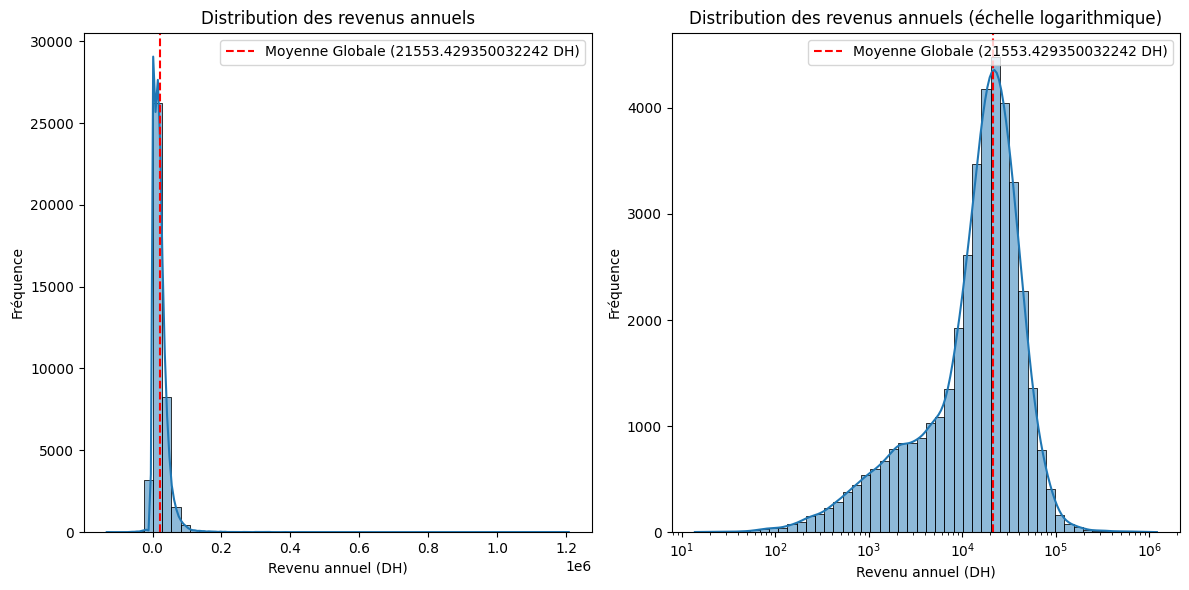

In [29]:
# Distribution des revenus
plt.figure(figsize=(12, 6))
print(REVENU_MOYEN_GLOBAL_DATASET)
plt.subplot(1, 2, 1)
sns.histplot(df['revenu_annuel'].dropna(), bins=50, kde=True)
plt.axvline(REVENU_MOYEN_GLOBAL_DATASET, color='red', linestyle='--', label=f'Moyenne Globale ({REVENU_MOYEN_GLOBAL_DATASET} DH)')
plt.title('Distribution des revenus annuels')
plt.xlabel('Revenu annuel (DH)')
plt.ylabel('Fréquence')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df['revenu_annuel'].dropna(), bins=50, log_scale=True, kde=True)
plt.axvline(REVENU_MOYEN_GLOBAL_DATASET, color='red', linestyle='--', label=f'Moyenne Globale ({REVENU_MOYEN_GLOBAL_DATASET} DH)')
plt.title('Distribution des revenus annuels (échelle logarithmique)')
plt.xlabel('Revenu annuel (DH)')
plt.ylabel('Fréquence')
plt.legend()

plt.tight_layout()
plt.show()

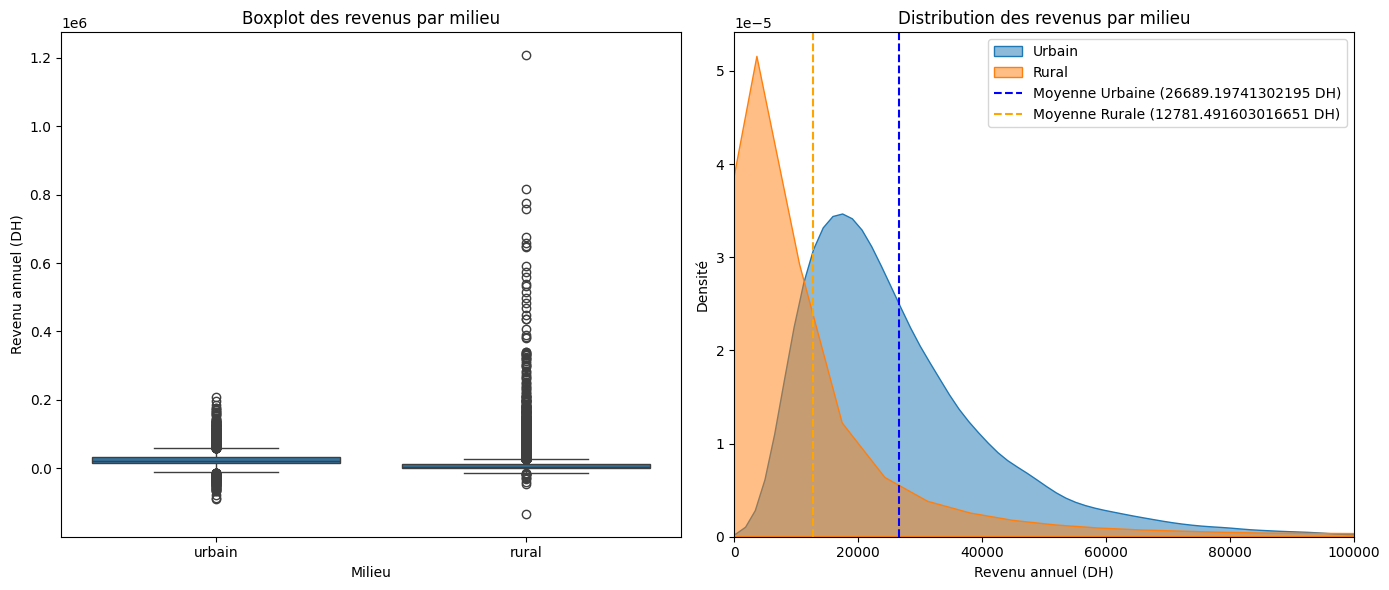

In [30]:
# Comparaison des revenus urbains et ruraux
plt.figure(figsize=(14, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x='milieu', y='revenu_annuel', data=df)
plt.title('Boxplot des revenus par milieu')
plt.xlabel('Milieu')
plt.ylabel('Revenu annuel (DH)')

# Densité
plt.subplot(1, 2, 2)
sns.kdeplot(data=df[df['milieu'] == 'urbain'], x='revenu_annuel', label='Urbain', fill=True, alpha=0.5)
sns.kdeplot(data=df[df['milieu'] == 'rural'], x='revenu_annuel', label='Rural', fill=True, alpha=0.5)
plt.axvline(REVENU_MOYEN_URBAIN_DATASET, color='blue', linestyle='--', label=f'Moyenne Urbaine ({REVENU_MOYEN_URBAIN_DATASET} DH)')
plt.axvline(REVENU_MOYEN_RURAL_DATASET, color='orange', linestyle='--', label=f'Moyenne Rurale ({REVENU_MOYEN_RURAL_DATASET} DH)')
plt.title('Distribution des revenus par milieu')
plt.xlabel('Revenu annuel (DH)')
plt.ylabel('Densité')
plt.legend()
plt.xlim(0, 100000)  # Limite l'axe x pour mieux visualiser

plt.tight_layout()
plt.show()

C:\Users\pepe\AppData\Local\Temp\ipykernel_2224\988148535.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='categorie_socioprofessionnelle', y='revenu_annuel', data=df, ci=None, order=sorted(df['categorie_socioprofessionnelle'].unique()))


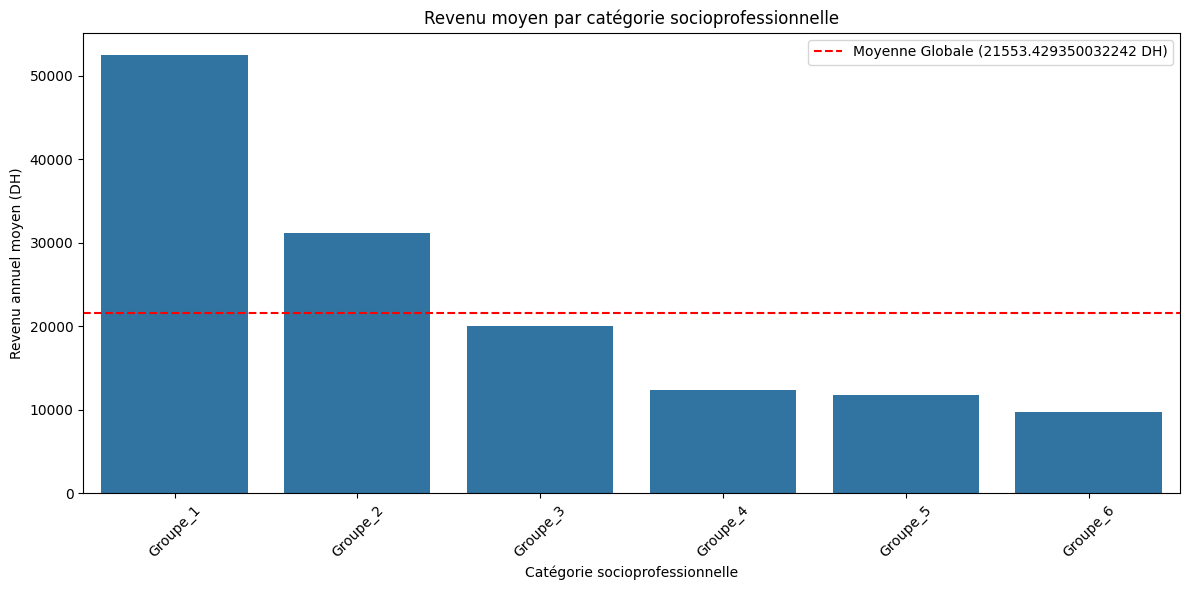

In [31]:
# Revenu moyen par catégorie socioprofessionnelle
plt.figure(figsize=(12, 6))
sns.barplot(x='categorie_socioprofessionnelle', y='revenu_annuel', data=df, ci=None, order=sorted(df['categorie_socioprofessionnelle'].unique()))
plt.axhline(REVENU_MOYEN_GLOBAL_DATASET, color='red', linestyle='--', label=f'Moyenne Globale ({REVENU_MOYEN_GLOBAL_DATASET} DH)')
plt.title('Revenu moyen par catégorie socioprofessionnelle')
plt.xlabel('Catégorie socioprofessionnelle')
plt.ylabel('Revenu annuel moyen (DH)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

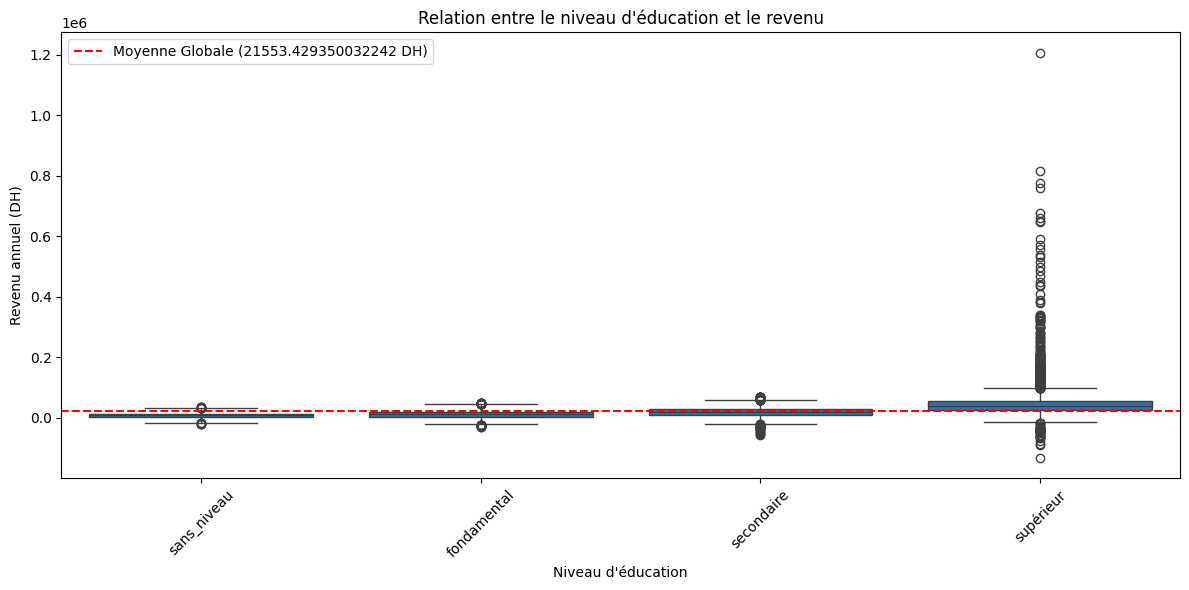

In [32]:
# Relation entre l'éducation et le revenu
plt.figure(figsize=(12, 6))
education_order = ['sans_niveau', 'fondamental', 'secondaire', 'supérieur']
sns.boxplot(x='niveau_education', y='revenu_annuel', data=df, order=education_order)
plt.axhline(REVENU_MOYEN_GLOBAL_DATASET, color='red', linestyle='--', label=f'Moyenne Globale ({REVENU_MOYEN_GLOBAL_DATASET} DH)')
plt.title('Relation entre le niveau d\'éducation et le revenu')
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Revenu annuel (DH)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

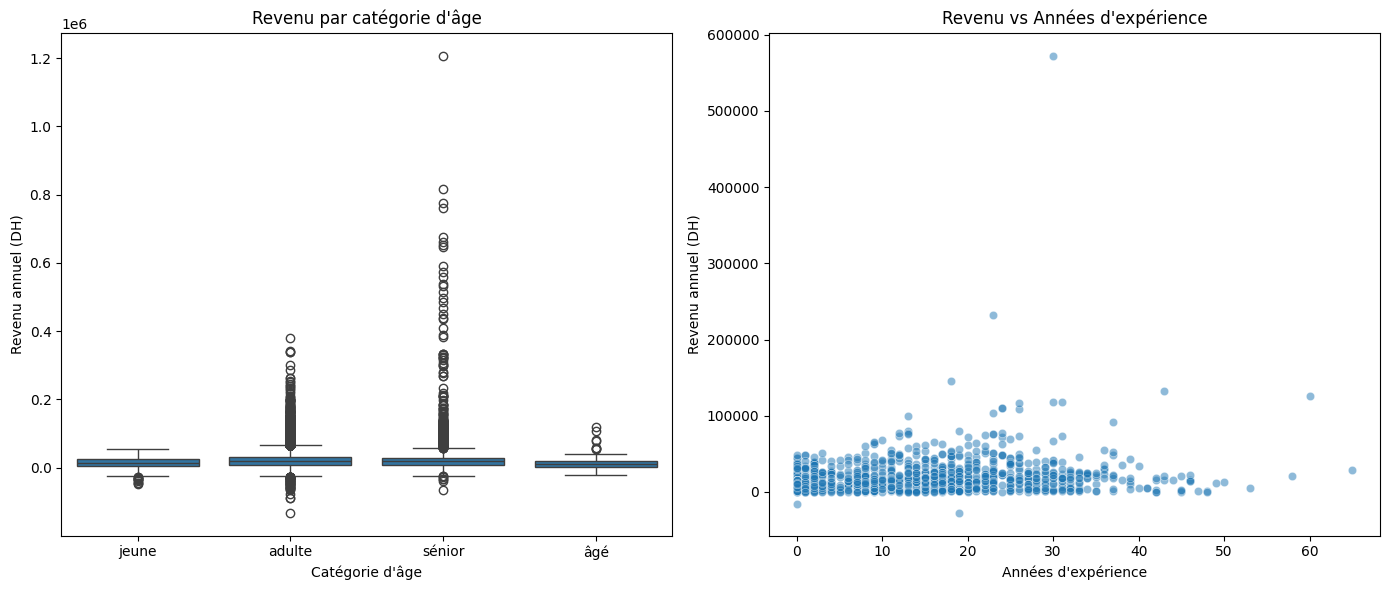

In [33]:
# Relation entre l'âge, l'expérience et le revenu
plt.figure(figsize=(14, 6))

# Revenu par catégorie d'âge
plt.subplot(1, 2, 1)
age_order = ['jeune', 'adulte', 'sénior', 'âgé']
sns.boxplot(x='categorie_age', y='revenu_annuel', data=df, order=age_order)
plt.title('Revenu par catégorie d\'âge')
plt.xlabel('Catégorie d\'âge')
plt.ylabel('Revenu annuel (DH)')

# Revenu vs années d'expérience
plt.subplot(1, 2, 2)
sns.scatterplot(x='annees_experience', y='revenu_annuel', data=df.sample(1000), alpha=0.5)  # Échantillon pour clarté
plt.title('Revenu vs Années d\'expérience')
plt.xlabel('Années d\'expérience')
plt.ylabel('Revenu annuel (DH)')

plt.tight_layout()
plt.show()

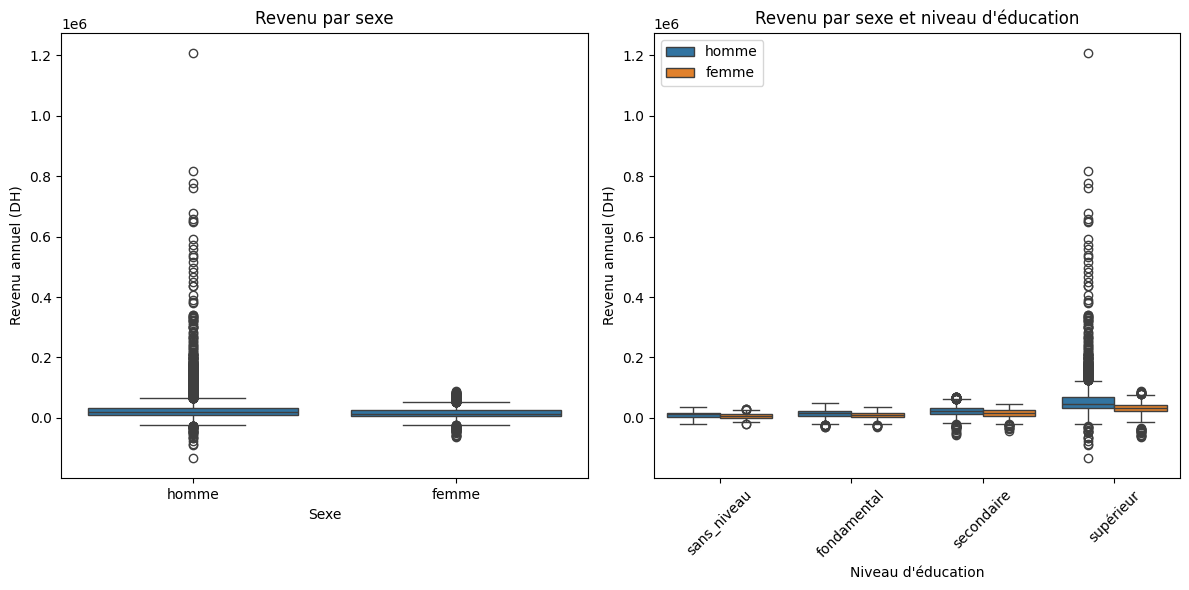

In [34]:
# Comparaison des revenus par sexe
plt.figure(figsize=(12, 6))

# Boxplot par sexe
plt.subplot(1, 2, 1)
sns.boxplot(x='sexe', y='revenu_annuel', data=df)
plt.title('Revenu par sexe')
plt.xlabel('Sexe')
plt.ylabel('Revenu annuel (DH)')

# Boxplot par sexe et niveau d'éducation
plt.subplot(1, 2, 2)
sns.boxplot(x='niveau_education', y='revenu_annuel', hue='sexe', data=df, order=education_order)
plt.title('Revenu par sexe et niveau d\'éducation')
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Revenu annuel (DH)')
plt.xticks(rotation=45)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### 4.2 Analyse exploratoire automatisée avec Sweetviz

Utilisons Sweetviz pour une analyse approfondie automatisée du jeu de données.

In [5]:
# Création du rapport Sweetviz
sweet_report = sv.analyze([df, "Dataset Complet"], target_feat='revenu_annuel')

# Sauvegarde du rapport au format HTML
sweet_report.show_html('rapport_sweetviz.html', open_browser=False)

print("Rapport Sweetviz généré et sauvegardé dans 'rapport_sweetviz.html'.")

                                             |          | [  0%]   00:00 -> (? left)

Report rapport_sweetviz.html was generated.
Rapport Sweetviz généré et sauvegardé dans 'rapport_sweetviz.html'.


## 5. Conclusion de la Phase 1

Dans cette première phase du projet, nous avons réussi à :

1. Générer un jeu de données synthétiques réaliste de 40 000 individus marocains avec leurs caractéristiques démographiques.
2. Créer un modèle de génération de revenus basé sur ces caractéristiques démographiques.
3. Ajuster les revenus générés pour respecter les contraintes statistiques du HCP concernant les moyennes et les distributions.
4. Ajouter des problèmes de qualité de données pour rendre le jeu de données plus réaliste et permettre l'application de techniques de nettoyage dans les phases ultérieures.
5. Explorer et visualiser les données pour comprendre les relations entre les différentes variables.

Dans la prochaine phase, nous allons préparer ces données pour la modélisation en effectuant les étapes de nettoyage et de transformation nécessaires, puis construire et évaluer différents modèles de régression pour prédire le revenu annuel.